In [1]:
import os
import random
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go


import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

from torchvision import transforms
from torchsummary import summary
from visdom import Visdom

import sys
sys.path.append("../modules/")
import helper as hp

device :  cuda
num gpu :  4


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') 
print('device : ', device)
print('num gpu : ', torch.cuda.device_count())

device :  cuda
num gpu :  4


In [3]:
class VaseDataset(data.Dataset):
    
    def __init__(self, length=100, width1=1, width2=1, error_range=0, x1_divide=1.0, x2_divide=1.0, y_divide=1.0, seed=None):
        if seed!=None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        self.length = length
        x1 = torch.empty(length, 1).uniform_(-width1,width1)
        x2 = torch.empty(length, 1).uniform_(-width2,width2)
        self.input = torch.cat( (x1/x1_divide, x2/x2_divide), dim=1)
        self.output = x1**2 + x2**2 + torch.empty(length, 1).uniform_(-error_range,error_range)/y_divide
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

In [4]:
def vase_function(x1, x2):
    return x1**2+x2**2
    
# hp.plot3D(true_function=vase_function)

In [5]:
class VaseRegressor(hp.BasicRegressor):
    
    def __init__(self):
        super(VaseRegressor, self).__init__()
        self.layer1 = nn.Linear(2, 200)

sample_net = VaseRegressor().to(device)
print(sample_net)
summary(sample_net, (32,2))

VaseRegressor(
  (layer1): Linear(in_features=2, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (last): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 200]             600
           Dropout-2              [-1, 32, 200]               0
            Linear-3              [-1, 32, 200]          40,200
           Dropout-4              [-1, 32, 200]               0
            Linear-5                [-1, 32, 1]             201
Total params: 41,001
Trainable params: 41,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.16
Estimated Total Size (MB): 0.35
---------------------------------------------------

In [11]:
dataset = VaseDataset(length=30000,width1=1.5,width2=1.5)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=1024,shuffle=True)

model = VaseRegressor()
model = hp.train(
    model, dataloader,
    num_epochs=20,lr=5e-3, 
    schedule_param={"mode":"min", "factor":0.1, "patience":5}, 
#     save_path="../logs/vase_function",
    )

-------------
Epoch 1/20
Loss:0.0329 
timer:  0.5410 sec.
-------------
Epoch 2/20
Loss:0.0010 
timer:  0.4459 sec.
-------------
Epoch 3/20
Loss:0.0005 
timer:  0.5690 sec.
-------------
Epoch 4/20
Loss:0.0003 
timer:  0.4425 sec.
-------------
Epoch 5/20
Loss:0.0003 
timer:  0.5363 sec.
-------------
Epoch 6/20
Loss:0.0002 
timer:  0.4769 sec.
-------------
Epoch 7/20
Loss:0.0002 
timer:  0.4669 sec.
-------------
Epoch 8/20
Loss:0.0002 
timer:  0.5653 sec.
-------------
Epoch 9/20
Loss:0.0002 
timer:  0.5992 sec.
-------------
Epoch 10/20
Loss:0.0002 
timer:  0.4967 sec.
-------------
Epoch 11/20
Loss:0.0002 
timer:  0.4821 sec.
-------------
Epoch 12/20
Loss:0.0002 
timer:  0.5231 sec.
-------------
Epoch 13/20
Loss:0.0002 
timer:  0.4279 sec.
-------------
Epoch 14/20
Loss:0.0002 
timer:  0.5696 sec.
-------------
Epoch 15/20
Loss:0.0002 
timer:  0.4427 sec.
-------------
Epoch 16/20
Loss:0.0002 
timer:  0.4552 sec.
-------------
Epoch 17/20
Loss:0.0002 
timer:  0.5213 sec.
------

In [7]:
# hp.plot3D(model=model, true_function=vase_function)

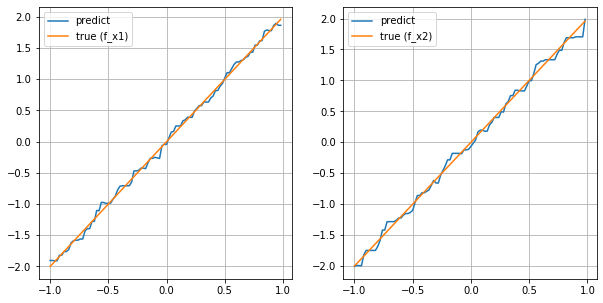

In [9]:
length = 100
start = -1
end = 1
waith = end - start
val_x = torch.tensor([[i, j] for i in np.arange(start,end,waith/length) for j in np.arange(start,end,waith/length)])
val_x1 = val_x[[i for i in range(length*length) if i%length==0],0]
val_x2 = val_x[:length,1]
pred_y = model(val_x).detach().cpu()

fig = plt.figure(figsize=(10,5))
pred_y = hp.NNgrad(model, val_x.to(device)).detach().cpu()
# pred_fx1, pred_fx2 = pred_y[:,0], pred_y[:,1]
pred_fx1 = [pred_y[i,0] for i in range(len(pred_y)) if i%length==0]
pred_fx2 = pred_y[:length,1]

ax1 = fig.add_subplot(1,2,1)
ax1.plot(val_x1, pred_fx1, label="predict")
ax1.plot(val_x1, 2*val_x1, label="true (f_x1)")
ax1.grid()
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(val_x2, pred_fx2, label="predict")
ax2.plot(val_x2, 2*val_x2, label="true (f_x2)")
ax2.grid()
ax2.legend(loc='upper left')

fig.show()